Aim: 
Make easy-peasy non spatial random forest model
- Calibate model
- tune hyperparameters
- Evaluate performance

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt

from scipy import stats, optimize
from sklearn.preprocessing import MinMaxScaler
#from sklearn import metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier # ,RandomForestRegressor
from sklearn.metrics import accuracy_score# , confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score

from scipy.stats import randint

import matplotlib.pyplot as plt
%matplotlib inline


seed = np.random.seed(11)


In [2]:
#df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_coords.xlsx")  # DF without Feature selection
#df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_ridge.xlsx")  # DF with Feature selection using Ridge Regularization
df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_lasso.xlsx")  # DF with Feature selection using Lasso Regularization

#df_candidates = gpd.GeoDataFrame(df_candidates, crs="EPSG:4326", geometry=gpd.points_from_xy(df_candidates.lat, df_candidates.lon))
df_candidates.tail(2)

,business_reduction,inundation_duration_h,water_depth_cm,warning_time_h,shp_damage_level_electronics,shp_damage_level_equipment,shp_damage_level_products,contaminations,protect_valuables_impl,water_barries_impl,...,elevation_building_height_cm,building_elevation_rel2surrounding_cat,shp_sector,shp_avgmonthly_sale_mVND,shp_capital_mVND,shp_risk_behaviour,shp_monetary_resources_prenvention,building_floor,elevation_m,Target_direct
502,70,2.0,10,0.0,2,4,2,2,1,4,...,150,0,17,1,10.0,2,1,1,4,2.0
503,100,5.0,20,0.0,1,1,1,2,1,1,...,100,0,17,2,50.0,3,3,0,3,0.0


In [3]:
# ## remove businesses without direct damage costs

# df_candidates.Target_direct.value_counts();
# df_candidates = df_candidates[df_candidates.Target_direct > 0.0]  # 136=0.0
# print(df_candidates.shape)


## workaround due nan- cols from df_num or df_agg 
df_candidates = df_candidates[[c for c in df_candidates if df_candidates[c].isnull().sum() < 100]]
#df_candidates.isna().sum()
df_candidates = df_candidates.fillna(0)

In [4]:
y = df_candidates.Target_direct.astype("int64")
X = df_candidates.drop(["Target_direct",# "elevation_m",
                        #"shp_sector.specify",   # fix this variable and make as numerbs
                        #"Q0.1",
                        #"geometry","lat","lon"
                        ], axis=1)

# scaler = MinMaxScaler() 
# X = scaler.fit_transform(X_unscaled.reshape(-1, 1))


### Discretized continous variabels: 
E.g. by an equal frequency discretization
use coarse discrete classes for each varible e.g. 5 classes used in Can ho City-DS

In [5]:
#X['shp_sector.specify'] = X[''shp_sector.specify'].map({'no':0,'yes':1,'unknown':0})


### split into train and test set
- Normalization not needed, is optional


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)#, stratify=y)

## TODO: solve problme of small classes in Target: ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
 

### Train and tune model

In [7]:
### tunning of hyperparamters by RandomizedSearchCV
param_dist = {'n_estimators': [10, 100, 200, 500],
              'max_depth': [1, 3, 5, 10,20],
              #'min_impurity_decrease':  [0.1, 0.3 0.5],   # similar to early stopping = pevent overfitting
              }# randint(1, 20)}


In [8]:
model = RandomForestClassifier(bootstrap=True, oob_score=True)
model.fit(X_train, y_train)

model_rs = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)


# Fit the model by randomizedSearchCV
model_rs.fit(X_train, y_train)

## predict unseen X_test set
y_pred = model_rs.predict(X_test)




c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Evaluation

In [12]:
## check for overfitting
print("Train Accuracy:", model_rs.score(X_train, y_train))
print("Test Accuracy:", model_rs.score(X_test, y_test))   # without elev 0.7894736842105263

# --> both scores are quite for away, we loss too much informatin during training, seems more like underfitting

Train Accuracy: 0.9857954545454546
Test Accuracy: 0.7828947368421053


### cross validation 
Assess effectivness of model
- using stratified K-fold - good for imbalanced class distributions due that each fold contains same % of samples of each target class, good bc target contains many small values and very few very high values
- access target (or any X var which tshould be used for propotion) as stratified in train_tes_split() 


In [10]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
# evaluae the model and collect the scores
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # error_score='raise')

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy:  {accuracy*100:.2f}%")  # without elevation = 75,25%, with elevation 72.21%

c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mean Accuracy: 0.719 (0.032)


In [11]:
X_train.shape

(352, 24)

#### Summary: Evaluation of adding predictor for elevation:
- Adding additional elevation height [meters above MSL] derived from 90m DEM, improves accurarcy by around 3 %
    - no FS: with elevation mean ACC ~ 74%, without Elevation ~ 71%
    - ridge FS: with elevation : ~70.7%  # 12 variables
    - lasso FS: with elevation : ~71.9%  # 24 variables
- For this only the most important hyperparameters -tree-depth and tree number -were tuned by RanomizedSearchCV ('n_estimators': [10, 100, 200, 500], 'max_depth': [1, 3, 5, 10,20])
- elevation height belongs to the 10 most important predictors so far


### Feature importance

In [12]:
importances = model.feature_importances_
#importances = np.sort(importances)#[:10]

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances) #  reverse sort[::-1]


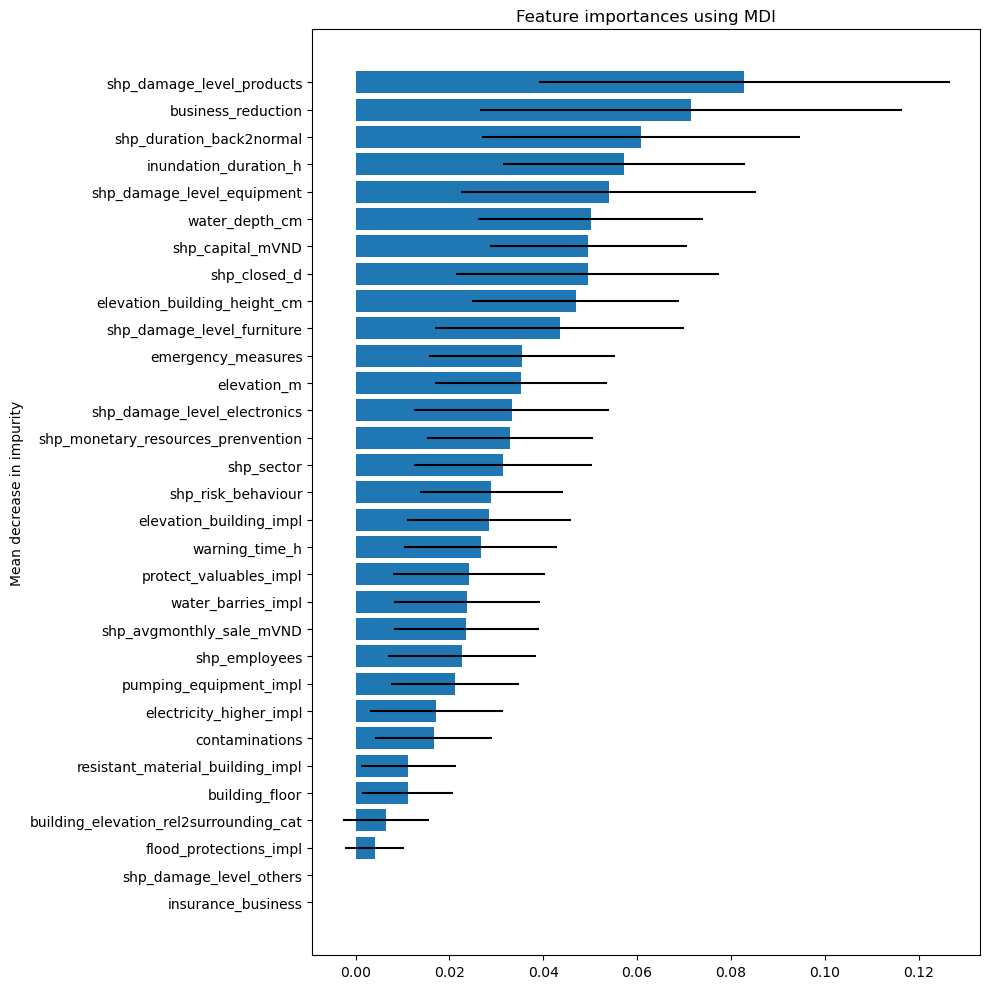

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

plt.barh(range(len(indices)), importances[indices], align='center',  xerr=std[indices])
plt.yticks(range(len(indices)), np.array(X.columns)[indices])
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#  fig, ax = plt.subplots(figsize=(10,10))
# num_features = X.shape[1]
# forest_importances.plot.bar(range(X.shape[1]), importances[indices], yerr=std[indices]) # yerr=std, ax=ax,
# #forest_importances.plot.barh(range(X.shape[1]), importances[indices[-num_features:]], align='center')#,  yerr=std[indices])


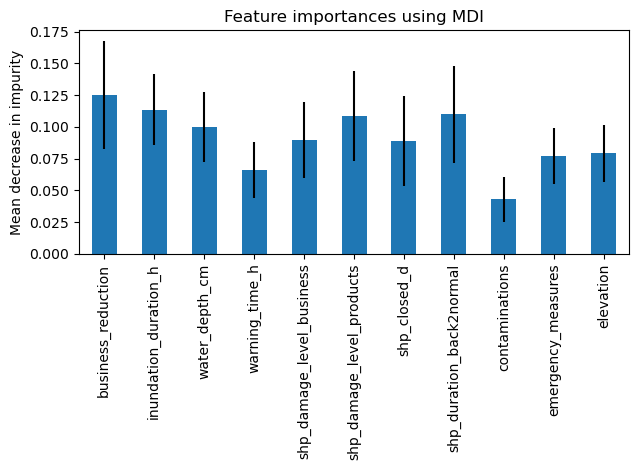

In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
print(classification_report(y_test, y_pred))  


              precision    recall  f1-score   support

           0       0.86      0.97      0.91        59
           1       0.44      0.36      0.40        11
           2       0.50      0.40      0.44         5
           3       1.00      0.67      0.80         3
           4       0.67      0.67      0.67         3
           5       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
          10       0.40      0.67      0.50         3
          15       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         0
          20       1.00      0.67      0.80         3
          30       1.00      1.00      1.00         2
          40       1.00      1.00      1.00         2
          50       1.00      1.00      1.00         1
          70       0.00      0.00      0.00         0
          97       0.00      0.00      0.00         1
          99       0.00      0.00      0.00         2
         280       1.00    

c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda\envs\py396_c3\lib\site-packages\sklearn\metrics\

#### Overall Acc, Kappa Coef, User+ producter accuacy, confusion matrix etc..

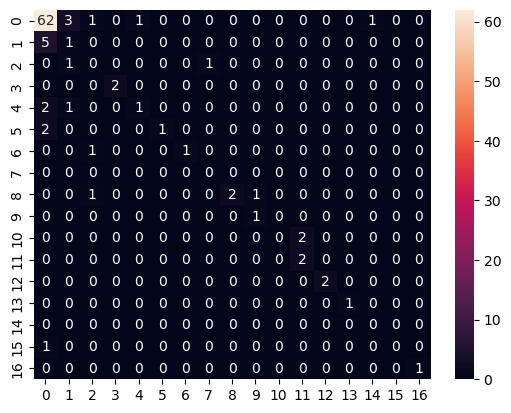

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

confusion_m =  confusion_matrix(y_test, y_pred)#, labels=["ant", "bird", "cat"])
#conf_mat = confusion_matrix(labels, predictions)

sns.heatmap(confusion_m, annot=True)
plt.show()


# disp = ConfusionMatrixDisplay.from_estimator( model,  X_test, y_test, 
#        display_labels=X_test.columns, cmap=plt.cm.Blues)
# disp.ax_.set_title("Confusion Matrix")
# print(disp.confusion_matrix)
# plt.show()


In [ ]:
y_test.shape

(101,)